In [2]:
# Scientific libraries
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context='notebook', fscale=1, ticks=True, grid=False)
plt.style.use('mike')

from threeML import *

import warnings
warnings.simplefilter('ignore')


## Data setup
We are going to use data from Fermi-LAT, Fermi-GBM and Swift-XRT. Let's go through the process of setting up the data from each instrument. We will work from high energy to low energy.


### Fermi-LAT
Once we have obtained the Fermi-LAT data, in this case, the LAT Low Energy (LLE) data, we can reduce the data into an plugin using the light curve tools provided in 3ML. LLE data is in the format of FITS event files with an associated spacecraft point history file and energy dispersion response. The **TimeSeriesBuilder** class has special methods for dealing with the LLE data.


Auto-determined polynomial order: 1




Binned 1-order polynomial fit with the Powell method




<IPython.core.display.Javascript object>


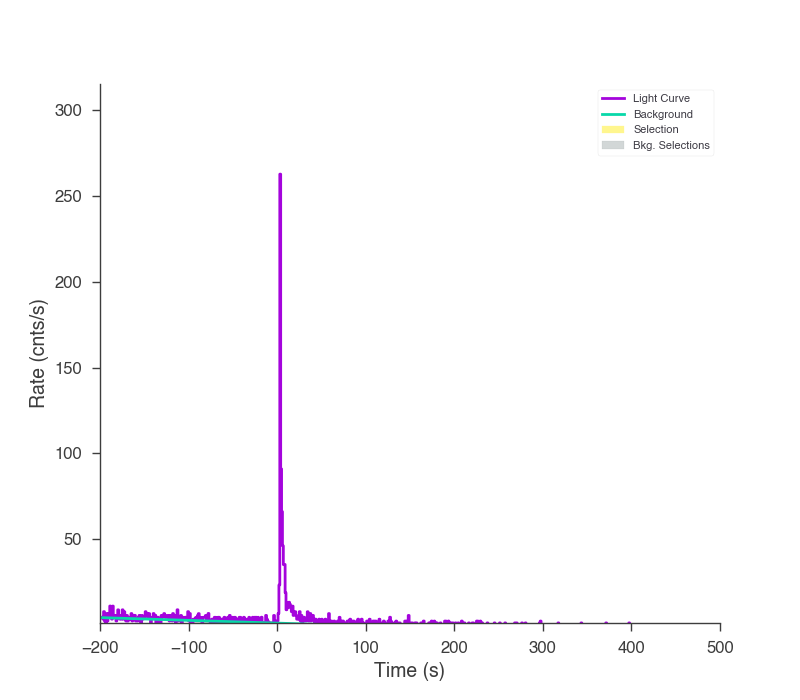

In [3]:


lle = TimeSeriesBuilder.from_lat_lle('lle',ft2_file="lle_pt.fit",
                                     lle_file="lle.fit",
                                     rsp_file="lle.rsp")
lle.set_background_interval('-100--10','150-500')

lle.set_active_time_interval('68-110')
lle.view_lightcurve(-200,500);


In [4]:
lle_plugin = lle.to_spectrumlike()
lle_plugin.use_effective_area_correction()

lle_plugin.display()

Auto-probed noise models:
- observation: poisson
- background: gaussian


,0
n. channels,50
total rate,1.47587
total bkg. rate,0.490761
total bkg. rate error,0.0342392
bkg. exposure,38.6214
bkg. is poisson,False
exposure,38.6214
is poisson,True
background,profiled
significance,6.61832


<IPython.core.display.Javascript object>


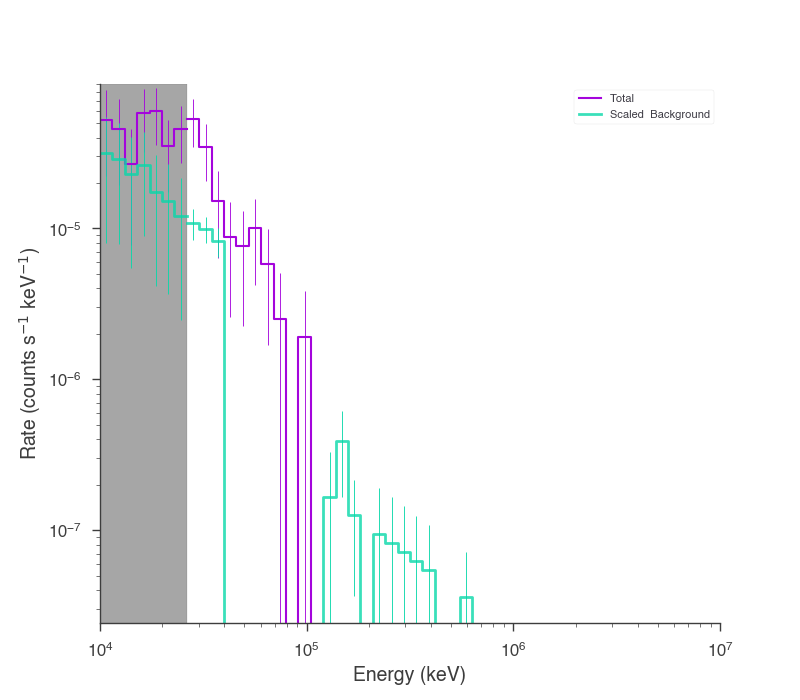

bad channels shown in red hatching



In [5]:
lle_plugin.view_count_spectrum();

### Fermi-GBM

In [7]:
gbm_detectors = ["n4", "n7", "n8", "b0"]

for det in gbm_detectors:
    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=f"cspec_{det}.pha", rsp_file=f"cspec_{det}.rsp2"
    )
    ts_cspec.set_background_interval("-400--10", "700-1200")

    ts_cspec.save_background(filename=f"{det}_bkg.h5", overwrite=True)

Auto-determined polynomial order: 2




Binned 2-order polynomial fit with the Powell method



Saved fitted background to n4_bkg.h5.



Auto-determined polynomial order: 1




Binned 1-order polynomial fit with the Powell method



Saved fitted background to n7_bkg.h5.



Auto-determined polynomial order: 1




Binned 1-order polynomial fit with the Powell method



Saved fitted background to n8_bkg.h5.



Auto-determined polynomial order: 4




Binned 4-order polynomial fit with the Powell method



Saved fitted background to b0_bkg.h5.



Successfully restored fit from n4_bkg.h5


<IPython.core.display.Javascript object>


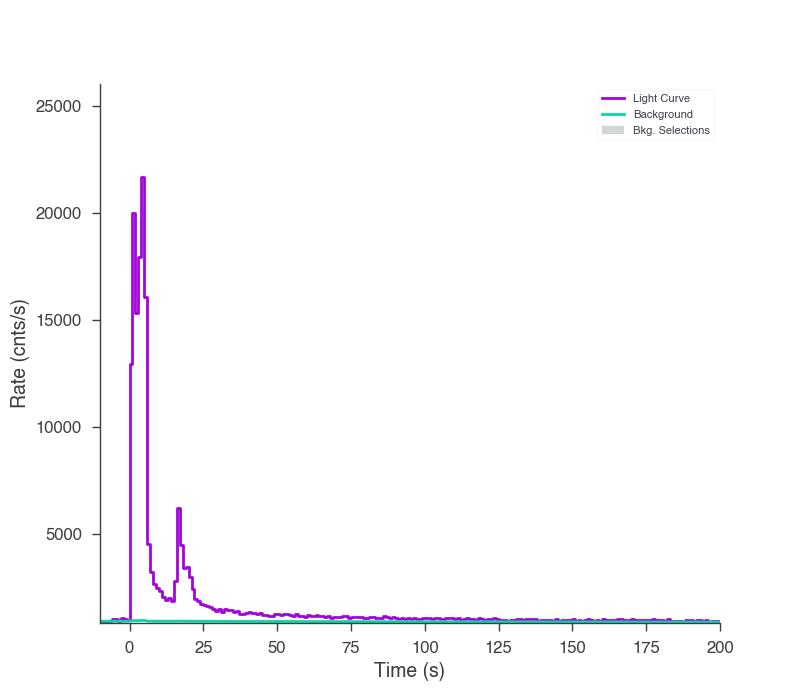

Auto-probed noise models:
- observation: poisson
- background: gaussian
Successfully restored fit from n7_bkg.h5


<IPython.core.display.Javascript object>


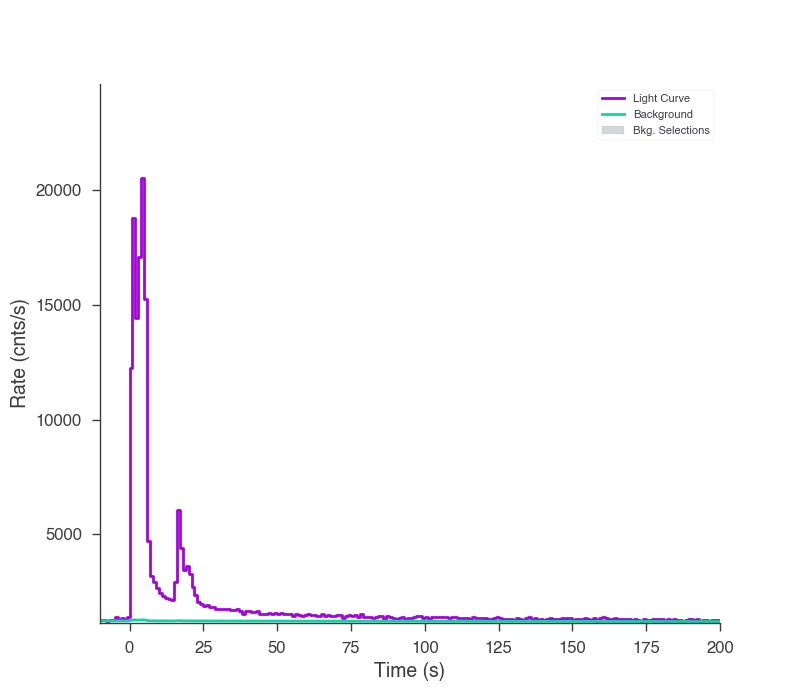

Auto-probed noise models:
- observation: poisson
- background: gaussian
Successfully restored fit from n8_bkg.h5


<IPython.core.display.Javascript object>


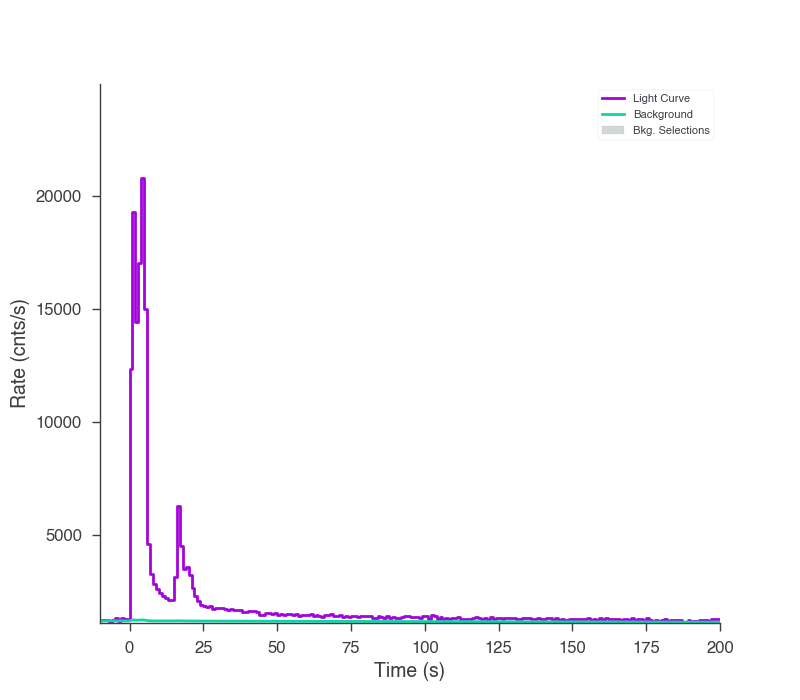

Auto-probed noise models:
- observation: poisson
- background: gaussian
Successfully restored fit from b0_bkg.h5


<IPython.core.display.Javascript object>


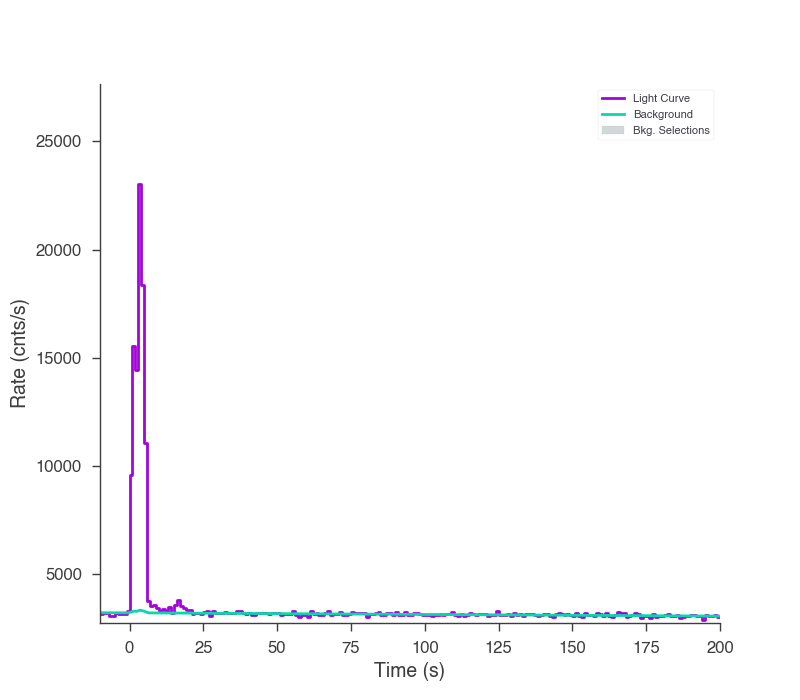

Auto-probed noise models:
- observation: poisson
- background: gaussian


In [8]:
gbm_time_series = {}
gbm_plugins = {}
for det in gbm_detectors:


    ts = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=f"tte_{det}.fit.gz",
        rsp_file=f"cspec_{det}.rsp2",
        restore_background=f"{det}_bkg.h5",
    )

    gbm_time_series[det] = ts

    ts.view_lightcurve(-10, 200)
    ts.set_active_time_interval("68-110")
    gbm_plugins[det] = ts.to_spectrumlike()

Range 10-900 translates to channels 6-123
Now using 118 channels out of 128
Now using 118 bins


<IPython.core.display.Javascript object>


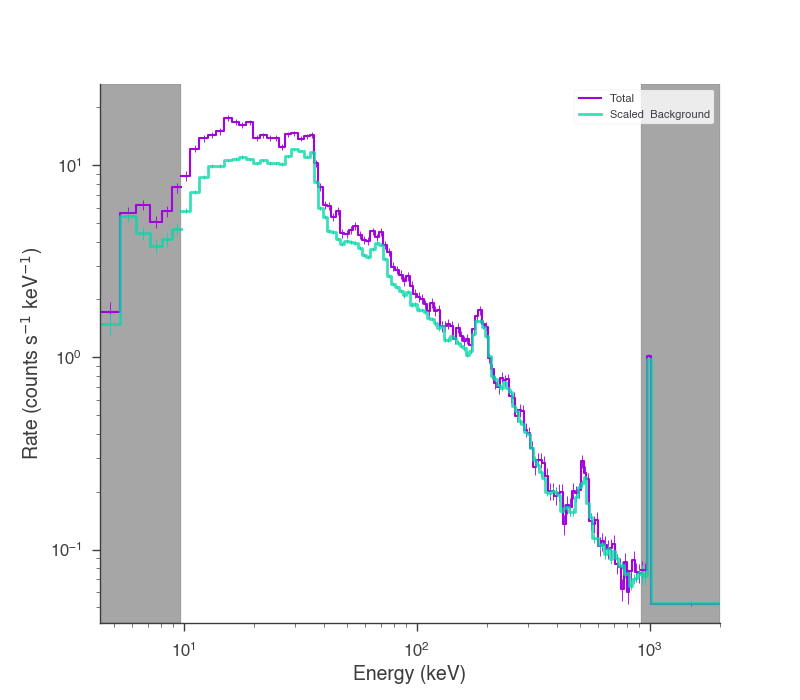

Range 10-900 translates to channels 6-122
Now using 117 channels out of 128
Now using 117 bins


<IPython.core.display.Javascript object>


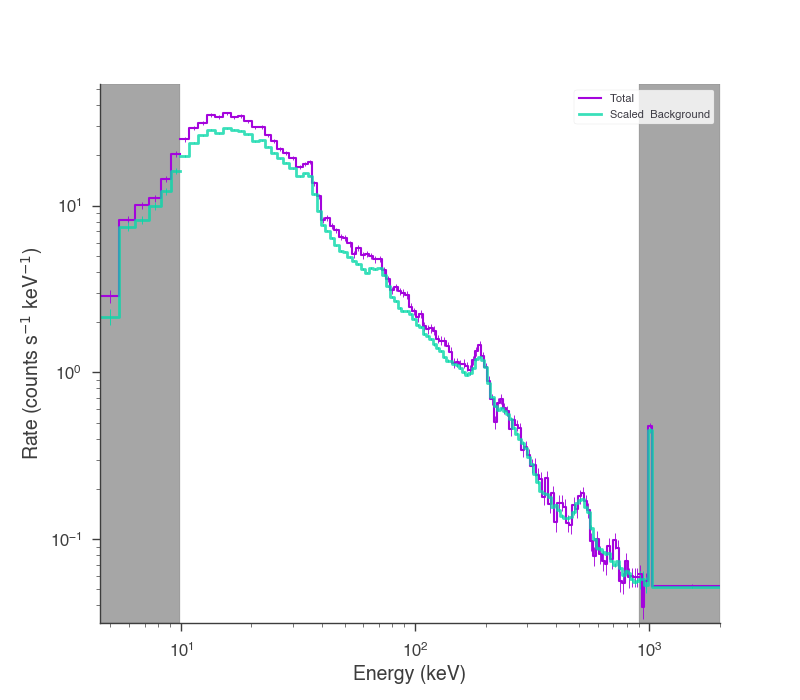

Range 10-900 translates to channels 5-124
Now using 120 channels out of 128
Now using 120 bins


<IPython.core.display.Javascript object>


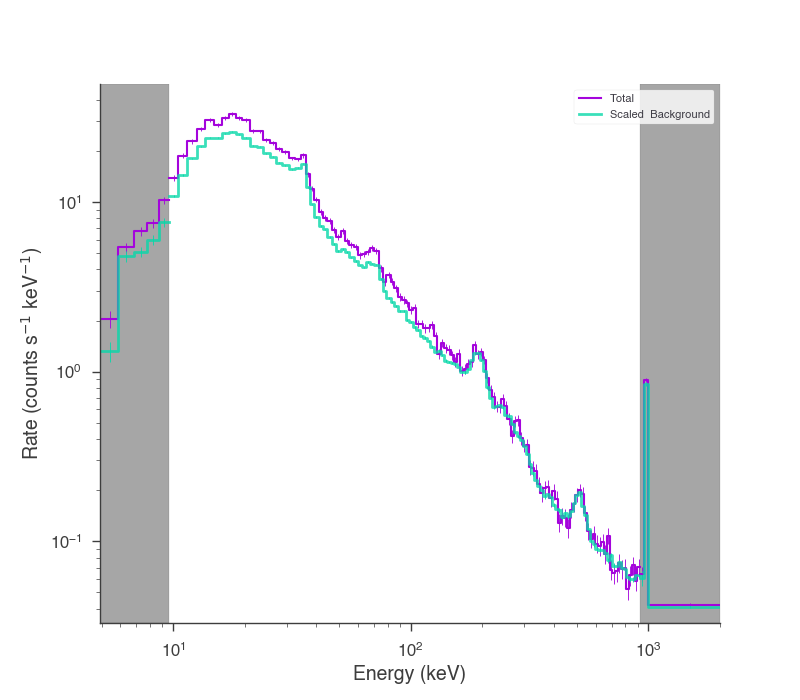

Range 250-30000 translates to channels 1-119
Now using 119 channels out of 128
Now using 119 bins


<IPython.core.display.Javascript object>


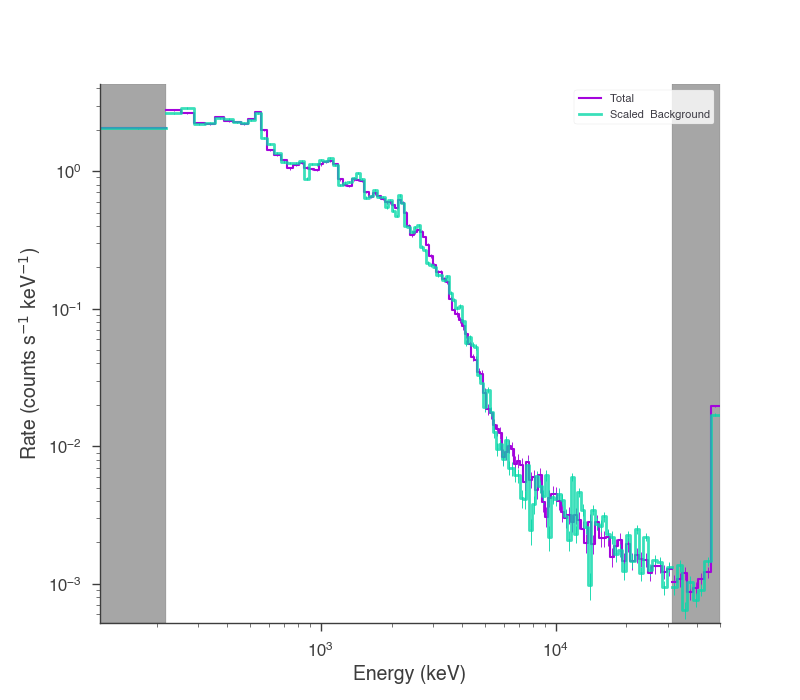

In [9]:
for det, plugin in gbm_plugins.items():

    if det.startswith("b"):

        plugin.set_active_measurements("250-30000")

    else:

        plugin.set_active_measurements("10-900")
        
    if det != "n3":
        
        plugin.use_effective_area_correction()

    plugin.rebin_on_background(1)
    plugin.view_count_spectrum()

### Swift-XRT

For Swift-XRT, we can use the normal **OGIPLike** plugin, but the energy resolution of the instrument is so fine that we would waste time integrating over the photon bins during forward-folding. Thus, there is a special plugin that overrides the computation of the photon integrals with a simple sum. 


In [10]:
xrt = SwiftXRTLike(
    "xrt",
    observation="awt.pi",
    background="awtback.pi",
    arf_file="awt.arf",
    response="awt.rmf",
)
xrt.display()

Auto-probed noise models:
- observation: poisson
- background: poisson


,0
pha file,awt.pi
bak file,awtback.pi
n. channels,1024
total rate,83.186
total bkg. rate,14.1426
bkg. exposure,41.9301
bkg. is poisson,True
exposure,41.9301
is poisson,True
background,profiled


Range 4-10 translates to channels 399-999
Now using 601 channels out of 1024
Now using 126 bins


<IPython.core.display.Javascript object>


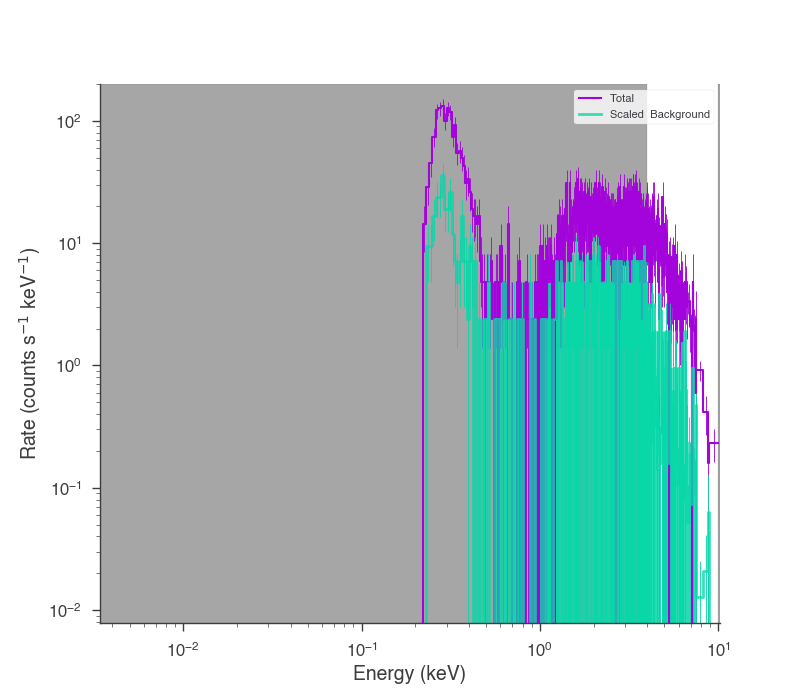

bad channels shown in red hatching



In [11]:
xrt.remove_rebinning()
xrt.set_active_measurements('4-10')

xrt.rebin_on_background(1.)
xrt.use_effective_area_correction()
xrt.view_count_spectrum();


### Combining all the plugins

In [12]:
all_plugins = [lle_plugin, xrt]
for _ , plugin in gbm_plugins.items():
    
    all_plugins.append(plugin)


datalist = DataList(*all_plugins)

## Fitting

### Model setup

#### Band Function

In [87]:
sbpl = SmoothlyBrokenPowerLaw(pivot=1E3)

sbpl.alpha.prior =  Truncated_gaussian(lower_bound=-1.5, upper_bound=0, mu=-1, sigma=.5)
sbpl.beta.prior =  Truncated_gaussian(lower_bound=-3., upper_bound=-1.6, mu=-2, sigma=.5)
sbpl.break_energy.prior = Log_uniform_prior(lower_bound=1, upper_bound=1E3)
sbpl.break_scale.prior =  Log_uniform_prior(lower_bound=1E-4, upper_bound=10.)
sbpl.K.prior = Log_uniform_prior(lower_bound=1E-2, upper_bound=1E2)
sbpl.K = 1E-1
sbpl.break_energy.bounds = (0, None)

sbpl.break_scale.free=True

ps = PointSource('grb',0,0,spectral_shape=sbpl)

model = Model(ps)

In [88]:
bayes = BayesianAnalysis(model,datalist)
bayes.set_sampler('multinest')

In [89]:
for k,v in model.free_parameters.items():
    if "cons" in k:
        
        v.prior = Truncated_gaussian(lower_bound=.8, upper_bound=1.2, mu=1, sigma=.1)
        
    

In [90]:

#bayes.sampler.setup(dlogz=10.,frac_remain=.5)
bayes.sampler.setup(n_live_points=1000)

bayes.sample()


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.SmoothlyBrokenPowerLaw.K,(1.0337334754696772 +/- 0) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.SmoothlyBrokenPowerLaw.alpha,(-1.1475734268003968 +/- 0) x 10^-2,
grb...break_energy,(9.844482197194324 +/- 0) x 10^2,keV
grb...break_scale,(4.919215623278564 +/- 0) x 10^-3,
grb.spectrum.main.SmoothlyBrokenPowerLaw.beta,-2.6919276342078162 +/- 0,
cons_lle,1.1979098907728958 +/- 0,
cons_xrt,(8.12842903943535 +/- 0) x 10^-1,
cons_n4,(8.162780021911873 +/- 0) x 10^-1,
cons_n7,1.0483008113637275 +/- 0,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0,-11425.112906
lle,-724.007797
n4,-10004.449933
n7,-15216.619289
n8,-10755.064845
total,-49309.797345
xrt,-1184.542575



Values of statistical measures:



,statistical measures
AIC,98641.833387
BIC,98696.806952
DIC,98617.295890
PDIC,0.000000
log(Z),-21471.928497


In [91]:
bayes.restore_median_fit()
#sbpl.K = 1E-1
display_spectrum_model_counts(bayes, min_rate=[-1,5,5,5,5,5]);

<IPython.core.display.Javascript object>

In [92]:
bayes.results.corner_plot();

AssertionError: I don't believe that you want more dimensions than samples!

In [ ]:
plot_point_source_spectra(bayes.results, flux_unit='erg2/(cm2 s keV)',ene_max =1E5);

## Fit